## load in trained model and dataset

In [1]:
import yaml
import mnist
import csv
import numpy as np
import torch
from torch import Tensor
from lvmogp_svi import LVMOGP_SVI
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *

# Load hyperparameters from .yaml file
with open('config_mnist_expri.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Assign hyperparameters from yaml file
root_path = config['root_path']
num_train_data = config['num_train_data']
latent_dim = config['latent_dim']
n_inducing_C = config['n_inducing_C']
n_inducing_X = config['n_inducing_X']
pca = config['pca']
num_forbidden = config['num_forbidden']
model_path = config['model_path']
likelihood_path = config['likelihood_path']
preprocessing_method = config['preprocessing_method']

# Other parameters...
mnist_training_data = Tensor(mnist.train_images()[:num_train_data])
mnist_training_data, param_dict = mnist_preprocess(mnist_training_data, method=preprocessing_method) # after pre-processing
print('training data shape', mnist_training_data.shape)

# define hyper-parameters
n_X = mnist_training_data.shape[0]
n_C = int(mnist_training_data.shape[-2] * mnist_training_data.shape[-1]) # also data_dim
n_total = n_X * n_C
Y_train = mnist_training_data.reshape(-1)
index_dim, C = gene_2dimage_inputs()

# specify model & likelihood
my_model = LVMOGP_SVI(n_X, n_C, index_dim, latent_dim, n_inducing_C, n_inducing_X, Y_train.reshape(n_X, -1), pca=pca)
likelihood = GaussianLikelihood() # how many outputs, 

# load in (partially)-trained model
load_model = True
load_likelihood = True
if load_model:
    _model_path = f'{model_path}/model_weights2.pth'
    state_dict = torch.load(_model_path)
    my_model.load_state_dict(state_dict)

if load_likelihood:
    _likelihood_path = f'{likelihood_path}/likelihood_weights2.pth'
    state_dict = torch.load(_likelihood_path)
    likelihood.load_state_dict(state_dict)

training data shape torch.Size([200, 28, 28])


## Plot latent vectors here

In [2]:
length_scale = [param.detach() for name, param in my_model.named_parameters() if name.startswith('covar_module_X')]
inverse_length_scale = (1 / length_scale[-1])[0]
print(inverse_length_scale)

# TODO: Why training leads to negative inverse_length_scale.

tensor([1.7719, 0.7106, 0.7128])


In [3]:
values, indices = torch.sort(abs(inverse_length_scale), descending=True)
print(indices)

tensor([0, 2, 1])


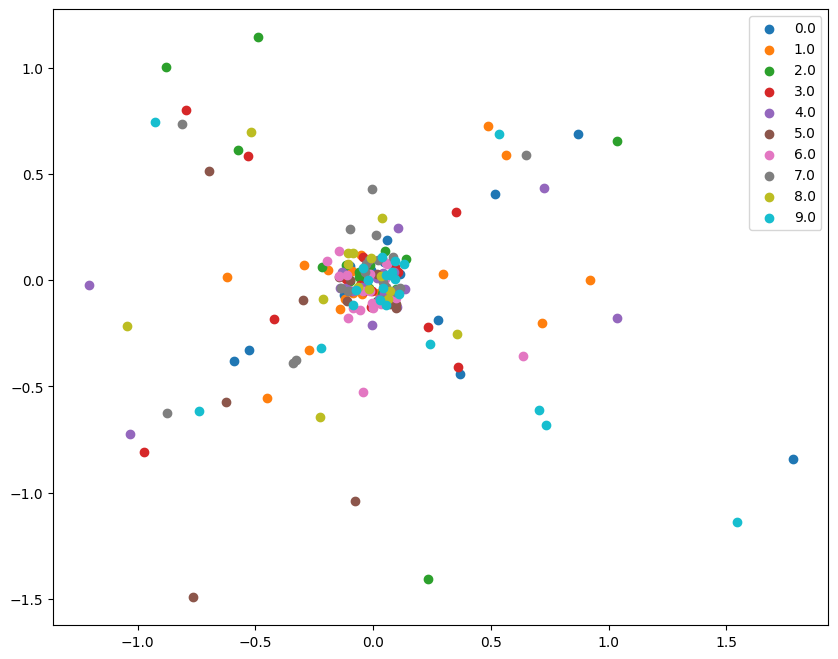

In [4]:
from util_functions import plot_2dlatent_with_label

latents_2d = my_model.X.q_mu.detach()[:, indices[:2]]
labels = Tensor(mnist.train_labels()[:num_train_data])

plot_2dlatent_with_label(latents_2d, labels)
# The latent space 
# TODO: To diagonise why latent space isn't learned at all? No pattern exist at all,
# and the x, y values are so small. 

## Missing Value Imputation

In [5]:
# evaluate trained model performance on forbidden set (regarded as test set/ missing values), compute RMSE and do some visualization staff.
from util_functions import *

forbidden_pairs_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/forbidden_pairs.csv'
first_element_list, second_element_list = extract_tuple_elements(forbidden_pairs_path)

sample_X = my_model.X.q_mu # TODO: try other meaningful approaches

sample_batch_X = sample_X[first_element_list]
sample_batch_C = C[second_element_list]

pred_outputs_ = my_model(sample_batch_X, sample_batch_C).loc.detach()
# transform pre-processed data back to original data
pred_outputs_ = revserse_mnist_preprocess(pred_outputs_, method=preprocessing_method, param_dict=param_dict)
target_indices_list = inhomogeneous_index_of_batch_Y(first_element_list, second_element_list, n_X, n_C)
target_outputs_ = Tensor(mnist.train_images()[:num_train_data]).reshape(-1)[target_indices_list]
assert pred_outputs_.shape == target_outputs_.shape

### RMSE

rmse is tensor(79.6049)
----------------------------------------------------------------------------------------------------
target min tensor(0.)
target max tensor(255.)
target mean tensor(32.0636)
----------------------------------------------------------------------------------------------------
pred min tensor(-2.6315)
pred max tensor(28.0661)
pred mean tensor(5.4789)


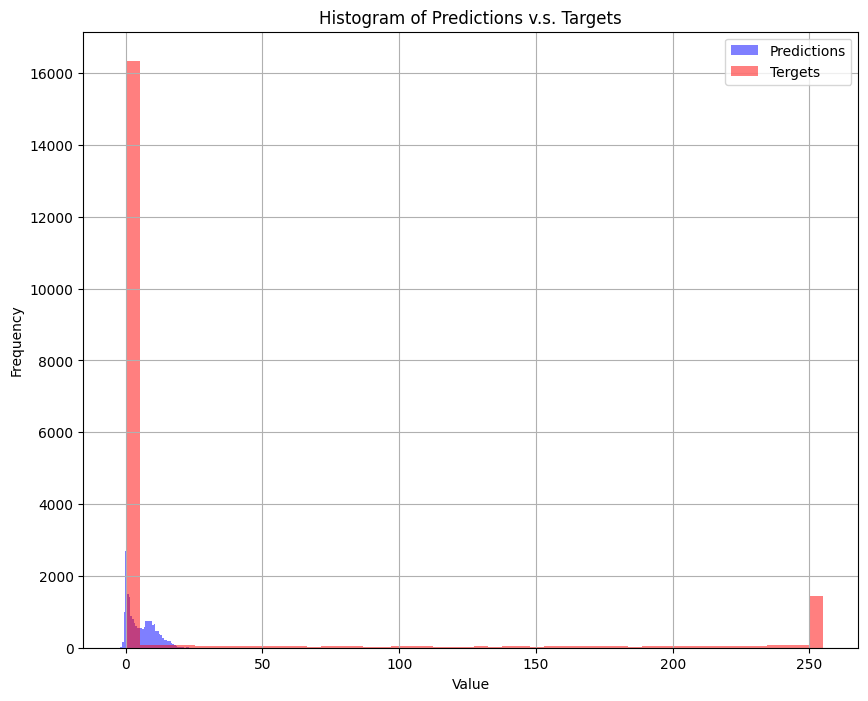

In [6]:
rmse = (pred_outputs_ - target_outputs_).square().mean().sqrt()

print('rmse is', rmse)
print('-----' * 20)
# This RMSE is huge!
print('target min', target_outputs_.min())
print('target max', target_outputs_.max())
print('target mean', target_outputs_.mean())
print('-----' * 20)
print('pred min', pred_outputs_.min())
print('pred max', pred_outputs_.max())
print('pred mean', pred_outputs_.mean())

# hist plot
plt.figure(figsize=(10, 8))
# Histogram for tensor_a
plt.hist(pred_outputs_, bins=50, alpha=0.5, label='Predictions', color='blue')
# Histogram for tensor_b
plt.hist(target_outputs_, bins=50, alpha=0.5, label='Tergets', color='red')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions v.s. Targets')
plt.legend()
plt.grid(True)
plt.show()
# Predictions are so small in terms of absolute value.
# TODO: To diagonise why this problem appear?

### Visually Plot Imputation results

In [7]:
def replace_elements(tensor_a, list_a, list_b):
    """
    Replaces elements in a 28x28 tensor according to a custom index list with values from another list.
    NOTE: rule1 means (0,0) - (27,27) indexing; rule2 referring to 0-783 indexing
    :param tensor_a: A 28x28 tensor (rule1).
    :param list_a: A list containing the custom indices (rule2) of the elements to replace.
    :param list_b: A list containing the values to replace the elements at the custom indices in tensor_a.
    :return: A 28x28 tensor with the elements replaced according to list_a and list_b.
    """
    # Create a copy of the original tensor to avoid modifying it directly
    tensor_b = tensor_a.clone()
    
    # Replace elements according to the rule2 indices
    for rule2_index, new_value in zip(list_a, list_b):
        # Convert rule2 index to row and column (rule1)
        row = rule2_index // 28
        column = rule2_index % 28
        # Replace the element in the tensor
        tensor_b[row, column] = new_value
    
    return tensor_b

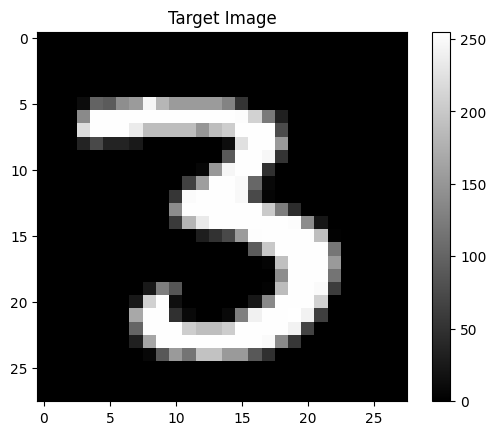

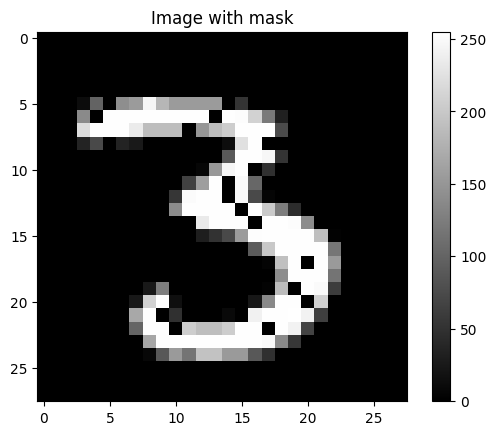

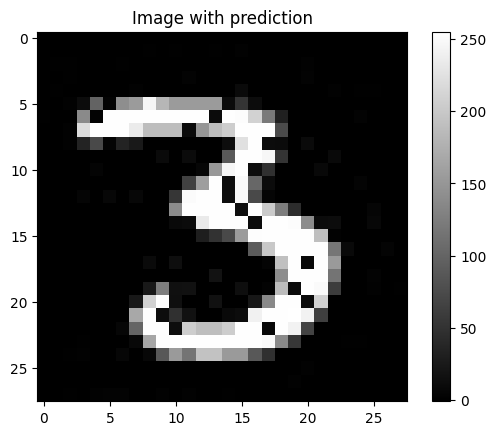

In [17]:
# TODO: reflect whether the number of missing values per image is too small.
# pick an image, do two plots: 
#   (1). plot original (whole) image 
#   (2). plot context pixels (training data) and prediction for missing values (masked during training).

num_missing_per_image = num_forbidden
image_index = 12 # 0 - mnist_training_data

image_target = Tensor(mnist.train_images()[:num_train_data])[image_index]
plt.imshow(image_target, cmap='gray')  # Use gray scale color map
plt.colorbar()  # Show the color bar
plt.title('Target Image')
plt.show()

# get indices of masked pixels (during training) for a certain image.
_position = [x == image_index for x in first_element_list]
forbidden_indices = np.array(second_element_list)[_position] # 0-783 indexing

list_b = [0 for i in range(num_missing_per_image)] # missing values per image. # TODO: how to make it easier to identify?
image_with_mask = replace_elements(image_target, forbidden_indices, list_b)
plt.imshow(image_with_mask, cmap='gray')  # Use gray scale color map
plt.colorbar()  # Show the color bar
plt.title('Image with mask')
plt.show()

pred_start = image_index * num_missing_per_image
pred_end = (image_index + 1) * num_missing_per_image
list_b_pred = pred_outputs_[pred_start : pred_end] # pick suitable index from pred_outputs_

image_with_pred = replace_elements(image_target, forbidden_indices, list_b_pred)
plt.imshow(image_with_pred, cmap='gray')  # Use gray scale color map
plt.colorbar()  # Show the color bar
plt.title('Image with prediction')
plt.show()

## Model Diagnosis

### have a look at learned parameters

In [9]:
for name, param in my_model.named_parameters():
    print(name)

variational_strategy.inducing_points_X
variational_strategy.inducing_points_C
variational_strategy._variational_distribution.variational_mean
variational_strategy._variational_distribution.chol_variational_covar_X
variational_strategy._variational_distribution.chol_variational_covar_C
X.q_mu
X.q_log_sigma
covar_module_X.raw_outputscale
covar_module_X.base_kernel.raw_lengthscale
covar_module_C.raw_outputscale
covar_module_C.base_kernel.raw_lengthscale


In [10]:
print('covar_module_X raw_output_scale\n', my_model.covar_module_X.outputscale.data)
print('covar_module_X base kernel lengthscale\n', my_model.covar_module_X.base_kernel.lengthscale.data)
print('covar_module_C raw_outputscale\n', my_model.covar_module_C.outputscale.data)
print('covar_module_C base_kernel lengthscale\n', my_model.covar_module_C.base_kernel.lengthscale.data)

covar_module_X raw_output_scale
 tensor(2.7790)
covar_module_X base kernel lengthscale
 tensor([[1.0146, 1.6262, 1.6227]])
covar_module_C raw_outputscale
 tensor(2.7790)
covar_module_C base_kernel lengthscale
 tensor([[2.2814, 2.3029]])


In [11]:
# print('X.q_mu', my_model.X.q_mu.data)
# print('X.q_log_sigma', my_model.X.q_log_sigma.data)
# print('variational_strategy._variational_distribution.chol_variational_covar_C', my_model.variational_strategy._variational_distribution.chol_variational_covar_C.data)
# print('variational_strategy._variational_distribution.chol_variational_covar_X', my_model.variational_strategy._variational_distribution.chol_variational_covar_X.data)
print('variational_strategy.inducing_points_C', my_model.variational_strategy.inducing_points_C.data)
# print('variational_strategy.inducing_points_X', my_model.variational_strategy.inducing_points_X.data)

variational_strategy.inducing_points_C tensor([[-12.4297,   9.1834],
        [ -2.6686,  -7.2456],
        [  1.1268,  -8.0296],
        [  2.5083,   5.1059],
        [ -7.7816,   6.8098],
        [  8.3525,   3.2071],
        [ 11.6956,  10.8765],
        [  1.2350,   1.8965],
        [ -2.2683,   6.8297],
        [ -4.3415,  12.2010],
        [ -2.0871,  -3.2084],
        [  2.6386,   9.2411],
        [ 14.0061, -11.0751],
        [-12.3296,   4.8557],
        [ -7.8820, -13.0617],
        [  1.9204, -14.3524],
        [  5.2887,   5.4629],
        [ -5.9024,   8.9695],
        [  9.4327,  14.3463],
        [  9.4979,  -7.4168],
        [  0.1987,  -0.8071],
        [ -5.1755,   4.0146],
        [  6.7403,   1.1388],
        [  3.1594,   0.3334],
        [ -3.7769,  15.0027],
        [  8.9942,  -0.4513],
        [ -6.9679, -12.2371],
        [ 10.1476,  -7.7347],
        [  7.3476,  -6.0589],
        [  7.9307,  -1.9678],
        [ -4.8173, -14.4676],
        [ 14.6532,   4.2113],
 

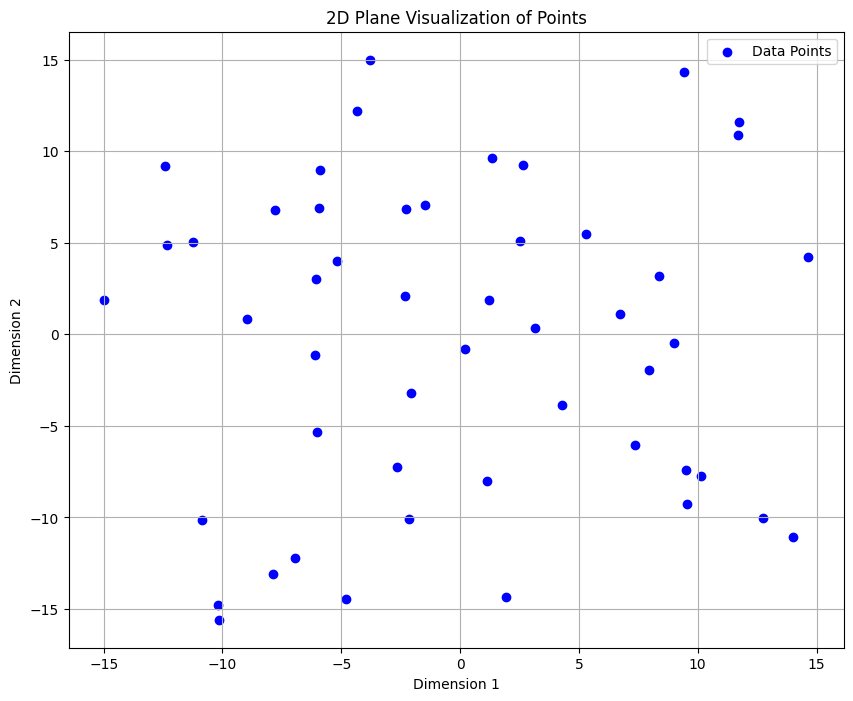

In [12]:
# We can visualize these points using matplotlib
tensor_to_plot = my_model.variational_strategy.inducing_points_C.data
plt.figure(figsize=(10, 8))
plt.scatter(tensor_to_plot[:, 0], tensor_to_plot[:, 1], c='blue', label='Data Points')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Plane Visualization of Points')
plt.legend()
plt.grid(True)
plt.show()